In [24]:
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

In [25]:
dataset = pd.read_csv('wdbc_data.csv')
dataset = dataset.drop(['id'], axis = 1)
dataset.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)
dataset.sample(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
104,0,10.490,19.29,67.41,336.1,0.09989,0.08578,0.029950,0.012010,0.2217,...,11.540,23.31,74.22,402.8,0.12190,0.14860,0.07987,0.03203,0.2826,0.07552
404,0,12.340,14.95,78.29,469.1,0.08682,0.04571,0.021090,0.020540,0.1571,...,13.180,16.85,84.11,533.1,0.10480,0.06744,0.04921,0.04793,0.2298,0.05974
490,0,12.250,22.44,78.18,466.5,0.08192,0.05200,0.017140,0.012610,0.1544,...,14.170,31.99,92.74,622.9,0.12560,0.18040,0.12300,0.06335,0.3100,0.08203
80,0,11.450,20.97,73.81,401.5,0.11020,0.09362,0.045910,0.022330,0.1842,...,13.110,32.16,84.53,525.1,0.15570,0.16760,0.17550,0.06127,0.2762,0.08851
71,0,8.888,14.64,58.79,244.0,0.09783,0.15310,0.086060,0.028720,0.1902,...,9.733,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840
306,0,13.200,15.82,84.07,537.3,0.08511,0.05251,0.001461,0.003261,0.1632,...,14.410,20.45,92.00,636.9,0.11280,0.13460,0.01120,0.02500,0.2651,0.08385
537,0,11.690,24.44,76.37,406.4,0.12360,0.15520,0.045150,0.045310,0.2131,...,12.980,32.19,86.12,487.7,0.17680,0.32510,0.13950,0.13080,0.2803,0.09970
460,1,17.080,27.15,111.20,930.9,0.09898,0.11100,0.100700,0.064310,0.1793,...,22.960,34.49,152.10,1648.0,0.16000,0.24440,0.26390,0.15550,0.3010,0.09060
38,1,14.990,25.20,95.54,698.8,0.09387,0.05131,0.023980,0.028990,0.1565,...,14.990,25.20,95.54,698.8,0.09387,0.05131,0.02398,0.02899,0.1565,0.05504
245,0,10.480,19.86,66.72,337.7,0.10700,0.05971,0.048310,0.030700,0.1737,...,11.480,29.46,73.68,402.8,0.15150,0.10260,0.11810,0.06736,0.2883,0.07748


In [26]:
features = list(dataset.columns[1:])
features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave_points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave_points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave_points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [27]:
def build_model(classifier_fn, 
                name_of_y_col, 
                names_of_X_cols, 
                dataset, 
                *hyperparameters):
    
    X = dataset[names_of_X_cols]
    Y = dataset[name_of_y_col]
    
    fa_obj, X = do_factor_analysis(X, Y, *hyperparameters)
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)
    
    model = classifier_fn(x_train, y_train)
    
    y_pred = model.predict(x_test)
    
    pred_results = pd.DataFrame({'y_test': y_test,
                               'y_pred': y_pred})
    
    model_crosstab = pd.crosstab(pred_results.y_pred, pred_results.y_test)
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    F1score = f1_score(y_test, y_pred)
    
    return{'fact_ana_obj': fa_obj,
           'transform_x': X,
           'Accuracy': acc,
           'Precision': pre,
           'Recall': rec,
           'ROC': roc,
           'F1 Score': F1score,
           'Confusion Matrix': model_crosstab
          }

In [28]:
def compare_results(result_dict):
    
    for key in result_dict:
        print('Test', key)
        print()
        print("Accuracy Score:", result_dict[key]['Accuracy'])
        print("Precision Score:", result_dict[key]['Precision'])
        print("Recall Score:", result_dict[key]['Recall'])
        print("F1 score:", result_dict[key]['F1 Score'])
        print("ROC:", result_dict[key]['ROC'])
        print()

In [29]:
def visualize_results(result_dict):
    
    n_components = list(range(0, 30))
    acc = [result_dict[key]['Accuracy'] for key in result_dict]
    pre = [result_dict[key]['Precision'] for key in result_dict]
    rec = [result_dict[key]['Recall'] for key in result_dict]
    
    plt.figure(figsize = (12, 10))
    plt.plot(n_components, acc, label = 'Accuracy')
    plt.plot(n_components, pre, label = 'Precision')
    plt.plot(n_components, rec, label = 'Recall')
    
    pylab.ylim([0.7, 1.2])
    
    plt.xlabel('n_components')
    plt.ylabel('Score')
    
    plt.legend()

In [30]:
def do_factor_analysis(x, y, n):
    
    fact_ana = FactorAnalysis(n_components = n, random_state = 42, max_iter = 10000)
    x_new = fact_ana.fit_transform(x, y)
    
    return fact_ana, pd.DataFrame(x_new)

In [31]:
def logistic_fn(x_train, y_train):
    model = LogisticRegression(solver = 'liblinear')
    model.fit(x_train, y_train)
    
    return model

In [32]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(logistic_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [33]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9239766081871345
Precision Score: 0.9642857142857143
Recall Score: 0.8307692307692308
F1 score: 0.8925619834710744
ROC: 0.9059506531204645

Test n_components - 2

Accuracy Score: 0.935672514619883
Precision Score: 1.0
Recall Score: 0.8333333333333334
F1 score: 0.9090909090909091
ROC: 0.9166666666666667

Test n_components - 3

Accuracy Score: 0.9122807017543859
Precision Score: 0.9655172413793104
Recall Score: 0.8115942028985508
F1 score: 0.8818897637795277
ROC: 0.8959931798806479

Test n_components - 4

Accuracy Score: 0.9473684210526315
Precision Score: 0.9649122807017544
Recall Score: 0.8870967741935484
F1 score: 0.9243697478991597
ROC: 0.9343740751701688

Test n_components - 5

Accuracy Score: 0.9707602339181286
Precision Score: 0.9655172413793104
Recall Score: 0.9491525423728814
F1 score: 0.9572649572649573
ROC: 0.9656476997578692

Test n_components - 6

Accuracy Score: 0.9824561403508771
Precision Score: 0.9818181818181818
Recall Score: 0.9

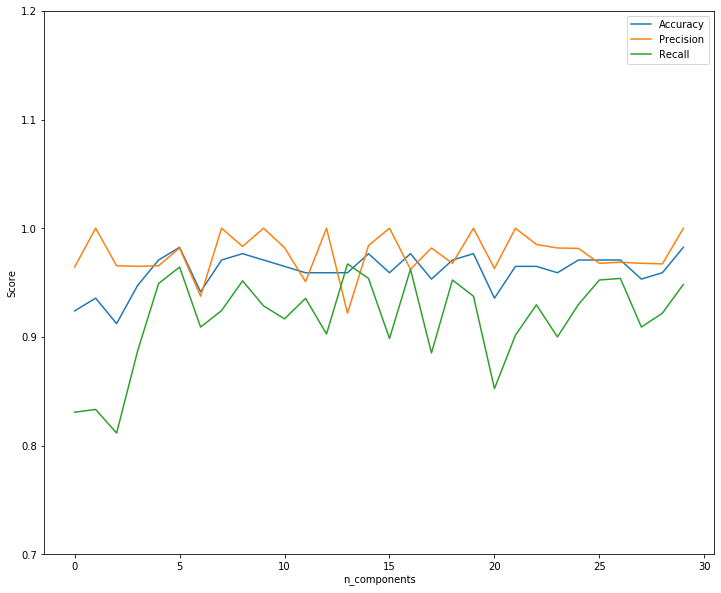

In [34]:
visualize_results(result_dict)

In [35]:
def rfc_fn(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
    model.fit(X_train, y_train)
        
    return model

In [36]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(rfc_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [37]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.8888888888888888
Precision Score: 0.8679245283018868
Recall Score: 0.7931034482758621
F1 score: 0.8288288288288289
ROC: 0.8655782728104975

Test n_components - 2

Accuracy Score: 0.9532163742690059
Precision Score: 0.8983050847457628
Recall Score: 0.9636363636363636
F1 score: 0.9298245614035089
ROC: 0.9559561128526646

Test n_components - 3

Accuracy Score: 0.9473684210526315
Precision Score: 1.0
Recall Score: 0.859375
F1 score: 0.9243697478991597
ROC: 0.9296875

Test n_components - 4

Accuracy Score: 0.935672514619883
Precision Score: 0.8615384615384616
Recall Score: 0.9655172413793104
F1 score: 0.9105691056910569
ROC: 0.9429356118400977

Test n_components - 5

Accuracy Score: 0.9473684210526315
Precision Score: 0.9473684210526315
Recall Score: 0.9
F1 score: 0.9230769230769231
ROC: 0.9364864864864865

Test n_components - 6

Accuracy Score: 0.9415204678362573
Precision Score: 0.9142857142857143
Recall Score: 0.9411764705882353
F1 score: 0.927536

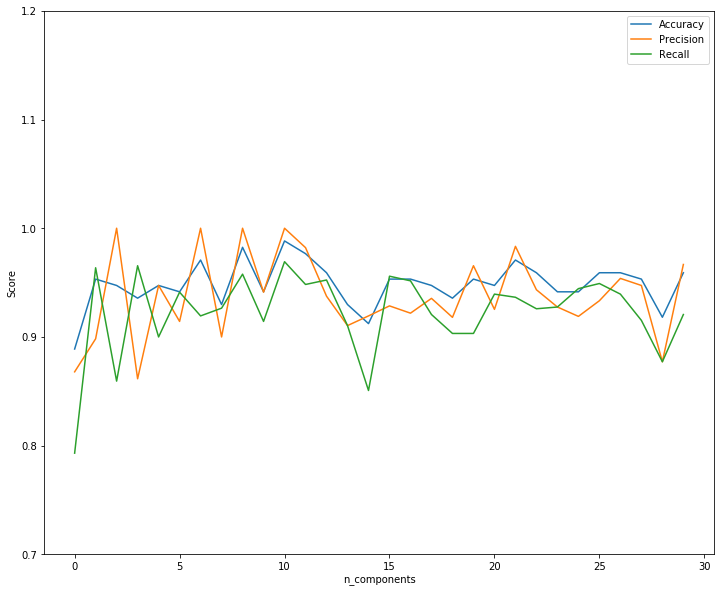

In [38]:
visualize_results(result_dict)

In [39]:
def stochastic_gradient_descent_fn(x_train, y_train, max_iter=10000, tol=1e-3):
    
    model = SGDClassifier(max_iter=max_iter, tol=tol)
    model.fit(x_train, y_train)
    
    return model

In [40]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(stochastic_gradient_descent_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [41]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.8771929824561403
Precision Score: 0.8955223880597015
Recall Score: 0.8108108108108109
F1 score: 0.851063829787234
ROC: 0.8693229311786014

Test n_components - 2

Accuracy Score: 0.9298245614035088
Precision Score: 0.9402985074626866
Recall Score: 0.8873239436619719
F1 score: 0.9130434782608696
ROC: 0.923661971830986

Test n_components - 3

Accuracy Score: 0.9415204678362573
Precision Score: 0.9516129032258065
Recall Score: 0.8939393939393939
F1 score: 0.921875
ROC: 0.9326839826839827

Test n_components - 4

Accuracy Score: 0.9064327485380117
Precision Score: 0.9322033898305084
Recall Score: 0.8208955223880597
F1 score: 0.873015873015873
ROC: 0.8912169919632607

Test n_components - 5

Accuracy Score: 0.9766081871345029
Precision Score: 0.9855072463768116
Recall Score: 0.9577464788732394
F1 score: 0.9714285714285714
ROC: 0.9738732394366197

Test n_components - 6

Accuracy Score: 0.9649122807017544
Precision Score: 0.9672131147540983
Recall Score: 

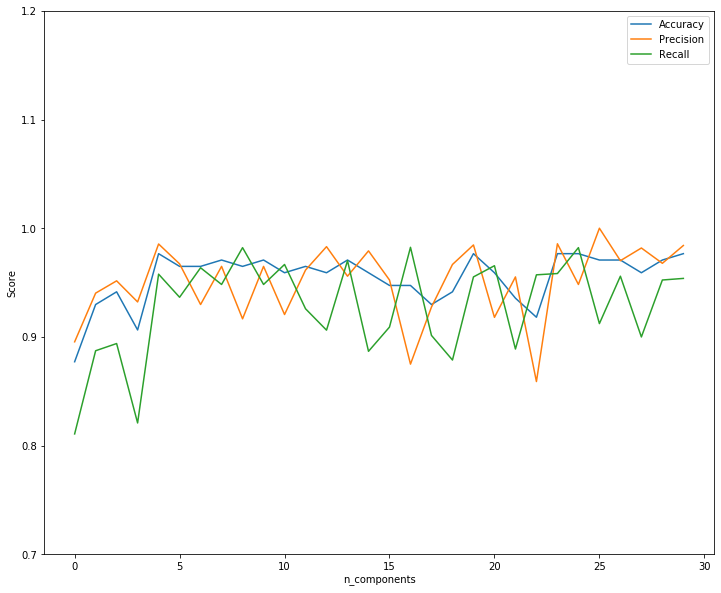

In [42]:
visualize_results(result_dict)

In [43]:
def svm_fn(x_train, y_train):
    model = SVC(kernel = 'linear')
    model.fit(x_train, y_train)
    
    return model

In [44]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(svm_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [45]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9298245614035088
Precision Score: 0.9264705882352942
Recall Score: 0.9
F1 score: 0.9130434782608695
ROC: 0.9252475247524752

Test n_components - 2

Accuracy Score: 0.9473684210526315
Precision Score: 0.9666666666666667
Recall Score: 0.8923076923076924
F1 score: 0.928
ROC: 0.9367198838896952

Test n_components - 3

Accuracy Score: 0.9064327485380117
Precision Score: 0.8867924528301887
Recall Score: 0.8245614035087719
F1 score: 0.8545454545454546
ROC: 0.8859649122807017

Test n_components - 4

Accuracy Score: 0.9532163742690059
Precision Score: 0.9649122807017544
Recall Score: 0.9016393442622951
F1 score: 0.9322033898305084
ROC: 0.9417287630402384

Test n_components - 5

Accuracy Score: 0.9590643274853801
Precision Score: 0.984375
Recall Score: 0.9130434782608695
F1 score: 0.9473684210526315
ROC: 0.9516197783461211

Test n_components - 6

Accuracy Score: 0.9824561403508771
Precision Score: 1.0
Recall Score: 0.9523809523809523
F1 score: 0.975609756

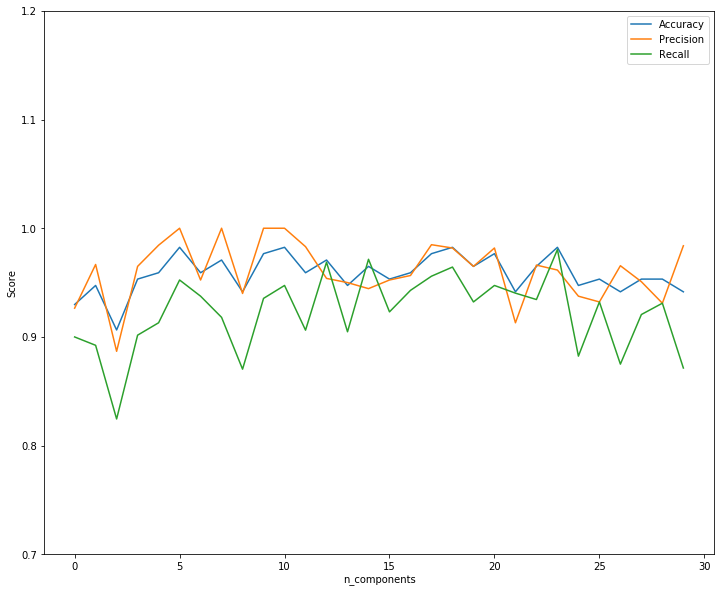

In [46]:
visualize_results(result_dict)

In [47]:
def KNN_fn(x_train, y_train):
    model = KNeighborsClassifier()
    model.fit(x_train, y_train)
    
    return model

In [48]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(KNN_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [49]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9122807017543859
Precision Score: 0.8873239436619719
Recall Score: 0.9
F1 score: 0.8936170212765958
ROC: 0.9103960396039604

Test n_components - 2

Accuracy Score: 0.9532163742690059
Precision Score: 0.95
Recall Score: 0.9193548387096774
F1 score: 0.9344262295081968
ROC: 0.9459159514649303

Test n_components - 3

Accuracy Score: 0.9239766081871345
Precision Score: 0.9838709677419355
Recall Score: 0.8356164383561644
F1 score: 0.9037037037037038
ROC: 0.9127061783617557

Test n_components - 4

Accuracy Score: 0.9415204678362573
Precision Score: 0.9636363636363636
Recall Score: 0.8688524590163934
F1 score: 0.9137931034482758
ROC: 0.9253353204172875

Test n_components - 5

Accuracy Score: 0.9473684210526315
Precision Score: 0.9272727272727272
Recall Score: 0.9107142857142857
F1 score: 0.918918918918919
ROC: 0.9379658385093167

Test n_components - 6

Accuracy Score: 0.9415204678362573
Precision Score: 0.9516129032258065
Recall Score: 0.893939393939393

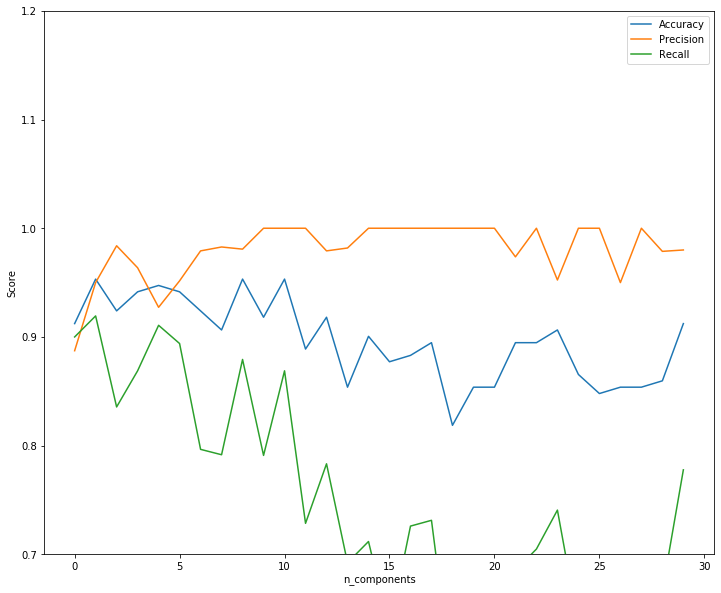

In [50]:
visualize_results(result_dict)

In [51]:
def DTC_fn(x_train, y_train):
    model = DecisionTreeClassifier()
    model.fit(x_train, y_train)
    
    return model

In [52]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(DTC_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [53]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9064327485380117
Precision Score: 0.9137931034482759
Recall Score: 0.828125
F1 score: 0.8688524590163935
ROC: 0.8906980140186916

Test n_components - 2

Accuracy Score: 0.8771929824561403
Precision Score: 0.8805970149253731
Recall Score: 0.8194444444444444
F1 score: 0.8489208633093526
ROC: 0.8693181818181819

Test n_components - 3

Accuracy Score: 0.8713450292397661
Precision Score: 0.8709677419354839
Recall Score: 0.7941176470588235
F1 score: 0.8307692307692308
ROC: 0.858223872073101

Test n_components - 4

Accuracy Score: 0.9415204678362573
Precision Score: 0.9375
Recall Score: 0.9090909090909091
F1 score: 0.923076923076923
ROC: 0.9354978354978355

Test n_components - 5

Accuracy Score: 0.9122807017543859
Precision Score: 0.9014084507042254
Recall Score: 0.8888888888888888
F1 score: 0.8951048951048951
ROC: 0.9090909090909091

Test n_components - 6

Accuracy Score: 0.8654970760233918
Precision Score: 0.7536231884057971
Recall Score: 0.896551724

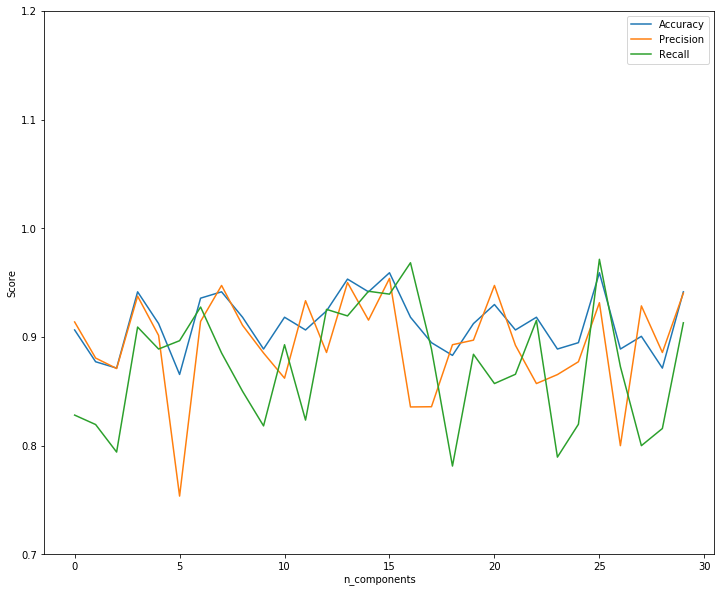

In [54]:
visualize_results(result_dict)

In [55]:
def ridge_fn(x_train, y_train):
    model = RidgeClassifier()
    model.fit(x_train, y_train)
    
    return model

In [56]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(ridge_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [57]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.8771929824561403
Precision Score: 0.9736842105263158
Recall Score: 0.6491228070175439
F1 score: 0.7789473684210527
ROC: 0.8201754385964912

Test n_components - 2

Accuracy Score: 0.8421052631578947
Precision Score: 1.0
Recall Score: 0.6086956521739131
F1 score: 0.7567567567567568
ROC: 0.8043478260869565

Test n_components - 3

Accuracy Score: 0.8947368421052632
Precision Score: 1.0
Recall Score: 0.6949152542372882
F1 score: 0.8200000000000001
ROC: 0.847457627118644

Test n_components - 4

Accuracy Score: 0.9064327485380117
Precision Score: 0.9814814814814815
Recall Score: 0.7794117647058824
F1 score: 0.8688524590163934
ROC: 0.8848515134209023

Test n_components - 5

Accuracy Score: 0.9239766081871345
Precision Score: 0.9615384615384616
Recall Score: 0.819672131147541
F1 score: 0.8849557522123893
ROC: 0.9007451564828614

Test n_components - 6

Accuracy Score: 0.9707602339181286
Precision Score: 0.9807692307692307
Recall Score: 0.9272727272727272


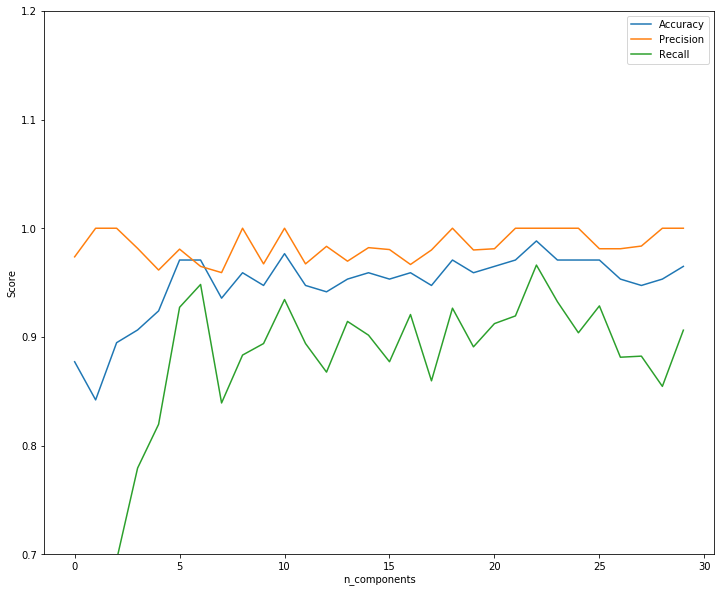

In [58]:
visualize_results(result_dict)

In [59]:
def GNB_fn(x_train, y_train):
    model = GaussianNB()
    model.fit(x_train, y_train)
    
    return model

In [60]:
result_dict = {}

for i in range(1, 31):
    result_dict['n_components - ' + str(i)] = build_model(GNB_fn,
                                                          'diagnosis',
                                                          features,
                                                          dataset,
                                                          i)

In [61]:
compare_results(result_dict)

Test n_components - 1

Accuracy Score: 0.9005847953216374
Precision Score: 0.9782608695652174
Recall Score: 0.7377049180327869
F1 score: 0.8411214953271028
ROC: 0.864307004470939

Test n_components - 2

Accuracy Score: 0.8888888888888888
Precision Score: 0.9183673469387755
Recall Score: 0.75
F1 score: 0.8256880733944955
ROC: 0.8569819819819819

Test n_components - 3

Accuracy Score: 0.8771929824561403
Precision Score: 0.8936170212765957
Recall Score: 0.7241379310344828
F1 score: 0.7999999999999999
ROC: 0.8399450717119316

Test n_components - 4

Accuracy Score: 0.9181286549707602
Precision Score: 0.9180327868852459
Recall Score: 0.8615384615384616
F1 score: 0.8888888888888888
ROC: 0.9071843251088534

Test n_components - 5

Accuracy Score: 0.9064327485380117
Precision Score: 0.8524590163934426
Recall Score: 0.8813559322033898
F1 score: 0.8666666666666666
ROC: 0.9004993946731233

Test n_components - 6

Accuracy Score: 0.9005847953216374
Precision Score: 0.8507462686567164
Recall Score: 0.

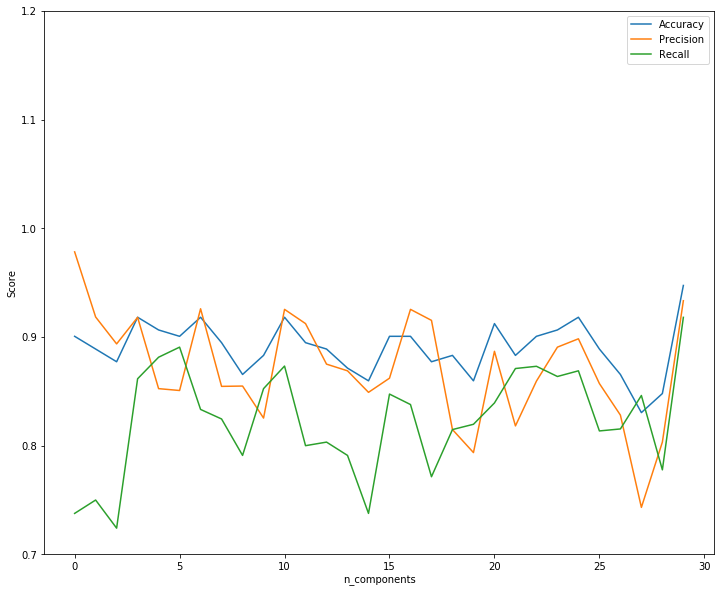

In [62]:
visualize_results(result_dict)